<a href="https://colab.research.google.com/github/aw814/dragonnet/blob/master/Dragonnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://causalforge.readthedocs.io/en/latest/user_guide/DragonNet.html

existing package that will implement Dragonnet and replicated the result using IHDP dataset

#Imports


In [1]:
# !pip install tensorflow==1.13.1
# !pip install numpy==1.23.5
!pip install pandas==1.5.0
!pip install scikit-learn
# !pip install keras==2.2.4
!pip install --upgrade tensorflow
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.0 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.6 MB/s eta 0:00:00
   

In [2]:
# !pip list


In [3]:
import os
import glob
import argparse
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Use TensorFlow's Keras API
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, TerminateOnNaN
import tensorflow.keras.backend as K

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Layer

# For using Keras backend functions directly
import tensorflow.keras.backend as K

import copy

from numpy import load

import numpy as np
from scipy.special import logit, expit
from scipy.optimize import minimize
import pandas as pd


#Dataset


## Data Description

The Infant Health and Development Program (IHDP) is a randomized controlled study designed to evaluate **the effect of home visit from specialist doctors on the cognitive test scores of premature infants**. The datasets is first used for benchmarking treatment effect estimation algorithms in Hill [1], where selection bias is induced by removing non-random subsets of the treated individuals to create an observational dataset, and the outcomes are generated using the original covariates and treatments.

The study uses 1000 realizations from the NPCI package, and data has 747 observations.

## Import Data and extract treatment, covariates and outcomes





> **Due to time constraints, this tutorial uses only 5 replications of the IHDP data, demonstrating the model's concept rather than providing precise replication of the study's results.**




In [4]:
from google.colab import drive
drive.mount('/content/drive')
DRAGONNET_DIR = '/content/drive/MyDrive/Dragonnet_SPPH'
DATA_BASE_DIR = os.path.join(DRAGONNET_DIR, 'dat/ihdp/csv')
print(DATA_BASE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Dragonnet_SPPH/dat/ihdp/csv


In [5]:
def load_and_format_covariates_ihdp(file_path):

    data = np.loadtxt(file_path, delimiter=',')

    binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    contfeats = [i for i in range(25) if i not in binfeats]

    mu_0, mu_1, x = data[:, 3][:, None], data[:, 4][:, None], data[:, 5:]
    perm = binfeats + contfeats
    x = x[:, perm]
    return x


def load_all_other_crap(file_path):
    data = np.loadtxt(file_path, delimiter=',')
    t, y, y_cf = data[:, 0], data[:, 1][:, None], data[:, 2][:, None]
    mu_0, mu_1, x = data[:, 3][:, None], data[:, 4][:, None], data[:, 5:]
    return t.reshape(-1, 1), y, y_cf, mu_0, mu_1



In [6]:
simulation_files = sorted(glob.glob("{}/*.csv".format(DATA_BASE_DIR)))
print(simulation_files)

# Specify the folder name
clean_data_dir = '/content/data_ihdp_clean'

if not os.path.exists(clean_data_dir):
    os.makedirs(clean_data_dir)
    print("Folder created:", clean_data_dir)
else:
    print("Folder already exists:", clean_data_dir)

for idx, simulation_file in enumerate(simulation_files):
  # x (covariates), t (treatment), y (factual outcome), y_cf (counterfactual outcome),
  # mu_0, mu_1 (noiseless potential outcomes)
  x = load_and_format_covariates_ihdp(simulation_file)
  t, y, y_cf, mu_0, mu_1 = load_all_other_crap(simulation_file)
  np.savez_compressed(os.path.join(clean_data_dir, f"simulation_{idx}"),
                      x=x, t=t, y=y, y_cf=y_cf, mu_0=mu_0, mu_1=mu_1)



['/content/drive/MyDrive/Dragonnet_SPPH/dat/ihdp/csv/ihdp_npci_1.csv', '/content/drive/MyDrive/Dragonnet_SPPH/dat/ihdp/csv/ihdp_npci_2.csv', '/content/drive/MyDrive/Dragonnet_SPPH/dat/ihdp/csv/ihdp_npci_3.csv', '/content/drive/MyDrive/Dragonnet_SPPH/dat/ihdp/csv/ihdp_npci_4.csv', '/content/drive/MyDrive/Dragonnet_SPPH/dat/ihdp/csv/ihdp_npci_5.csv']
Folder created: /content/data_ihdp_clean


## Data analysis

### Variables Description

- **x**: Covariates - These are the independent variables used in the analysis.
- **t**: Treatment - This indicates whether the treatment was applied or not.
- **y**: Factual Outcome - The outcome observed under the treatment or control given to the subject.
- **y_cf**: Counterfactual Outcome - The hypothetical outcome that would have been observed had the subject received the opposite treatment. *[not used in this study]*
- **mu_0**: Noiseless Potential Outcome (Control) - The estimated outcome if the subject did not receive the treatment.
- **mu_1**: Noiseless Potential Outcome (Treatment) - The estimated outcome if the subject did receive the treatment.



In [7]:
def summarize_datasets(data_base_dir):
    simulation_files = sorted(glob.glob(f"{data_base_dir}/*.npz"))
    summary = []

    for idx, simulation_file in enumerate(simulation_files):
        # Load data from the .npz file
        with np.load(simulation_file) as data:
            summary_info = {
                'File': os.path.basename(simulation_file),
                'Num_Observations': data['x'].shape[0],
                'Variables': list(data.files)
            }

            stats = {}
            for key in data.files:
                array = data[key]
                stats[key] = {
                    'Min': np.min(array),
                    'Max': np.max(array),
                    'Mean': np.mean(array),
                    'Std': np.std(array)
                }

            summary_info['Summary_Stats'] = stats
            summary.append(summary_info)

    return summary

# Usage
data_base_dir = '/content/data_ihdp_clean'  # Adjust as necessary
dataset_summary = summarize_datasets(data_base_dir)
for file_summary in dataset_summary:
    print("File:", file_summary['File'])
    print("Number of Observations:", file_summary['Num_Observations'])
    for var, stats in file_summary['Summary_Stats'].items():
        print(f"{var} - Min: {stats['Min']}, Max: {stats['Max']}, Mean: {stats['Mean']:.2f}, Std: {stats['Std']:.2f}")
    print("\n")

File: simulation_0.npz
Number of Observations: 747
x - Min: -5.13042776464339, Max: 2.99036883104816, Mean: 0.29, Std: 0.70
t - Min: 0.0, Max: 1.0, Mean: 0.19, Std: 0.39
y - Min: -1.54390231866209, Max: 11.2682277695966, Mean: 3.16, Std: 2.18
y_cf - Min: -1.03762755274036, Max: 10.17100383354, Mean: 5.70, Std: 1.98
mu_0 - Min: 0.924453299405036, Max: 9.82179228262831, Mean: 2.43, Std: 1.28
mu_1 - Min: 5.59164731549982, Max: 7.95480367858421, Mean: 6.45, Std: 0.45


File: simulation_1.npz
Number of Observations: 747
x - Min: -5.13042776464339, Max: 2.99036883104816, Mean: 0.29, Std: 0.70
t - Min: 0.0, Max: 1.0, Mean: 0.19, Std: 0.39
y - Min: 0.752065610550019, Max: 10.9136260076176, Mean: 5.02, Std: 2.09
y_cf - Min: 1.34851563310086, Max: 11.1649051337305, Mean: 7.54, Std: 1.93
mu_0 - Min: 2.50180296062162, Max: 9.13922520956693, Mean: 4.24, Std: 1.05
mu_1 - Min: 7.79380038854291, Max: 9.08936434502746, Mean: 8.29, Std: 0.23


File: simulation_2.npz
Number of Observations: 747
x - Min: 

# Motivation

* Improve the estimation of treatment effects from observational data using neural networks.

* Address the challenge of potential confounding factors that can lead to incorrect causal conclusions if not properly adjusted for.

Two NN designs are invented to improve the quality of treatment effect estimates:

1. Dragonnet Architecture: This new neural network architecture **utilizes the sufficiency of the propensity score** for causal estimation, aiming to better adjust for confounding factors in the estimation process.

2. Targeted Regularization: This is a regularization procedure that helps **induce a bias towards models with non-parametrically optimal asymptotic properties**, enhancing the estimation quality of treatment effects.

These adaptations are based on insights from statistical literature on treatment effect estimation and are intended to outperform existing methods.







# The two steps for using neural networks to estimate treatment effects:

1. Fit models for the conditional outcome and the propensity score.
2. Plug predictions from the models into a dowstream estimator


# Step 1: Model for the conditional outcome and the propensity score

- The model for the conditional outcome:
$$
Q(t, x) = \mathbb{E}[Y \mid t, x]
$$
where \( Q(t, x) \) represents the expected value of the outcome \( Y \) given the treatment \( t \) and covariates \( x \).

- The model for the propensity score:
$$
g(x) = P(T = 1 \mid x)
$$
where \( g(x) \) estimates the probability of receiving the treatment given the covariates \( x \).


#### Proposed models

*  Dragonnet
*  Dragonnet + targeted regularization



---

General steps for each of the model will be:
1.   Make the model by defining model architecture
2.   train/fit the model
3.   make predictions
4.   store the predicted outputs ŷ_0, ŷ_1 and ĝ




## 🐲 Dragonnet

### 1. Model architecture

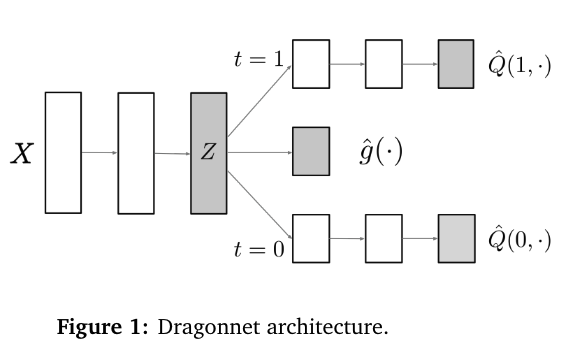

In [43]:
def make_dragonnet(input_dim, reg_l2):

    inputs = Input(shape=(input_dim,), name='input')

    # representation
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(inputs)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)

    # t_predictions = Dense(units=1, activation='sigmoid')(inputs)
    # ***** (3) propensity score g layer ****
    t_predictions = Dense(units=1, activation='sigmoid')(x)

    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(
        y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(
        y1_hidden)

    concat_pred = Concatenate(1)([y0_predictions, y1_predictions, t_predictions])

    model = Model(inputs=inputs, outputs=concat_pred)

    return model



### 2. fit model


The loss function (the objective function) is defined and dependent on the two terms:
* Mean squared error for regression tasks, in this case the outcome model.
* Cross-entropy loss for classification tasks, in this case the exposure model (proensity score prediction).


---


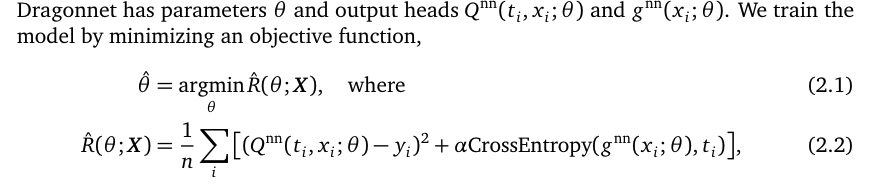

In [44]:
# Define the loss functions
# minimize errors/loss for propensity score prediction (for exposure model)
def binary_classification_loss(concat_true, concat_pred):
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    # stabilizing the training process by avoiding issues with logarithmic calculations
    # in the next step (binary cross-entropy)
    t_pred = (t_pred + 0.001) / 1.002
    # Binary cross-entropy loss is a common choice for binary classification tasks
    # it measures the "distance" between the actual t and the predicted t
    losst = tf.reduce_sum(K.binary_crossentropy(t_true, t_pred))

    return losst

# minimize prediction errors separately for treated and untreated groups(for outcome model)
def regression_loss(concat_true, concat_pred):
    y_true = concat_true[:, 0]
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    loss0 = tf.reduce_sum((1. - t_true) * tf.square(y_true - y0_pred))
    loss1 = tf.reduce_sum(t_true * tf.square(y_true - y1_pred))

    return loss0 + loss1


# minimize both the prediction error for outcome + exposure models.
def dragonnet_loss_binarycross(concat_true, concat_pred):
    return regression_loss(concat_true, concat_pred) + binary_classification_loss(concat_true, concat_pred)


def treatment_accuracy(concat_true, concat_pred):
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    return tf.keras.metrics.binary_accuracy(t_true, t_pred)





In [45]:
# Define metrics
metrics = [regression_loss, binary_classification_loss, treatment_accuracy]

In [46]:
# Helper function to split and format the predicted output later
def _split_output(yt_hat, t, y, y_scaler, x, index):
    q_t0 = y_scaler.inverse_transform(yt_hat[:, 0].reshape(-1, 1))
    q_t1 = y_scaler.inverse_transform(yt_hat[:, 1].reshape(-1, 1))
    g = yt_hat[:, 2].copy()

    if yt_hat.shape[1] == 4:
        eps = yt_hat[:, 3][0]
        print('eps is trained')
    else:
        eps = np.zeros_like(yt_hat[:, 2])
        print('eps will be zero')

    y = y_scaler.inverse_transform(y.copy())
    var = "average propensity for treated: {} and untreated: {}".format(g[t.squeeze() == 1.].mean(),
                                                                        g[t.squeeze() == 0.].mean())
    print(var)

    # q_t0,q_t1 -> predicted outcomes under (0,1) treatment
    # g -> predicted propensity score
    # t -> treatment
    # y -> original y before transformation
    # index
    # eps -> epsilon
    return {'q_t0': q_t0, 'q_t1': q_t1, 'g': g, 't': t, 'y': y, 'x': x, 'index': index, 'eps': eps}


####Start training below

> Note: the default code use all the data for prediction and estimation. If you want to get the in-sample or out-sample error:  change the train_test_split criteria.



In [47]:
train_outputs = []
test_outputs = []
all_scaled_y = []
for idx, realization_data in enumerate(sorted(glob.glob("{}/*.npz".format('/content/data_ihdp_clean')))):
  # Prepare data for training (by default use all the data for train and prediction)
  print(realization_data)
  data = load(realization_data)
  x, t, y_unscaled = data['x'], data['t'], data['y']
  verbose = 0
  # ********(1) Transform of Y outcome *****************
  y_scaler = StandardScaler().fit(y_unscaled)
  y = y_scaler.transform(y_unscaled)
  # Collect scaled y values
  all_scaled_y.extend(y)

  i = 0
  tf.random.set_seed(i)
  np.random.seed(i)
  # If you want to get the in-sample or out-sample error:
  # i) change the train_test_split criteria
  train_index, test_index = train_test_split(np.arange(x.shape[0]), test_size=0.01, random_state=1)
  # ii) comment out the following: ----------
  all_index = np.append(train_index, test_index)
  print("All indices shape:", all_index.shape)
  test_index = all_index
  train_index = all_index
  # -------------------------------
  print("Train indices shape:", train_index.shape)
  print("Test indices shape:", test_index.shape)

  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  t_train, t_test = t[train_index], t[test_index]

  # two column matrix col1 = y,col 2 = t
  yt_train = np.concatenate([y_train, t_train], 1)

  # ********(2) Model Configuration (G-comp) ******************
  # Each takes the number of features (x.shape[1]) and a regularization parameter (0.01) as inputs.
  dragonnet = make_dragonnet(x.shape[1], 0.01)

  # Start training
  import time;
  start_time = time.time()
  val_split = 0.2
  batch_size = 64
  loss = dragonnet_loss_binarycross
  metrics = metrics


  dragonnet.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=loss, metrics=metrics)

  adam_callbacks = [
      TerminateOnNaN(),
      EarlyStopping(monitor='val_loss', patience=2, min_delta=0.),
      ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=1e-8, cooldown=0, min_lr=0)

  ]

  dragonnet.fit(x_train, yt_train, callbacks=adam_callbacks,
                validation_split=val_split,
                epochs=100,
                batch_size=batch_size, verbose=verbose)

  sgd_callbacks = [
      TerminateOnNaN(),
      EarlyStopping(monitor='val_loss', patience=40, min_delta=0.),
      ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=0., cooldown=0, min_lr=0)
  ]

  sgd_lr = 1e-5
  momentum = 0.9
  dragonnet.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True), loss=loss,
                    metrics=metrics)
  dragonnet.fit(x_train, yt_train, callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size, verbose=verbose)

  elapsed_time = time.time() - start_time
  print("***************************** elapsed_time is: ", elapsed_time)

  yt_hat_test = dragonnet.predict(x_test)
  print("yt_hat_test shape:", yt_hat_test.shape)
  yt_hat_train = dragonnet.predict(x_train)
  print("yt_hat_train shape:", yt_hat_train.shape)

  test_outputs += [_split_output(yt_hat_test, t_test, y_test, y_scaler, x_test, test_index)]
  train_outputs += [_split_output(yt_hat_train, t_train, y_train, y_scaler, x_train, train_index)]


/content/data_ihdp_clean/simulation_0.npz
All indices shape: (747,)
Train indices shape: (747,)
Test indices shape: (747,)
***************************** elapsed_time is:  15.868285894393921
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
yt_hat_test shape: (747, 3)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
yt_hat_train shape: (747, 3)
eps will be zero
average propensity for treated: 0.2505907416343689 and untreated: 0.1538398712873459
eps will be zero
average propensity for treated: 0.2505907416343689 and untreated: 0.1538398712873459
/content/data_ihdp_clean/simulation_1.npz
All indices shape: (747,)
Train indices shape: (747,)
Test indices shape: (747,)
***************************** elapsed_time is:  20.537538051605225
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
yt_hat_test shape: (747, 3)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
yt_hat_train shape: (747, 3)
eps will be zero
average propensity for treated: 0.24706833064556122 and untreated: 0.15511751174926758
eps will be zero
average propensity for t

In [48]:
# Calculate and print the range of all scaled y values
all_scaled_y = np.array(all_scaled_y)
y_min, y_max = np.min(all_scaled_y), np.max(all_scaled_y)
y_mean = np.mean(all_scaled_y)
y_median = np.median(all_scaled_y)
print("Range of all y's after scaling: Min =", y_min, ", Max =", y_max)
print("Mean of all y's after scaling:", y_mean)
print("Median of all y's after scaling:", y_median)

Range of all y's after scaling: Min = -2.6341970939601964 , Max = 3.722149855023028
Mean of all y's after scaling: -3.04382430312225e-17
Median of all y's after scaling: -0.1787182750220682


### Predicted outputs description

- **`q_t0`, `q_t1`**: Predicted outcomes under treatments 0 and 1, respectively.
- **`g`**: Predicted propensity score, estimating the probability of receiving the treatment given covariates.
- **`t`**: Indicator of treatment.
- **`y`**: Original outcome variable before any transformations.
- **`index`**: Unique identifier for each observation.



In [63]:
# Function to calculate summary statistics
def calculate_summary_statistics(values):
    summary = {
        'mean': np.mean(values),
        'median': np.median(values),
        'min': np.min(values),
        'max': np.max(values)
    }
    return summary

# Initialize a dictionary to store summaries
summaries = {key: {'mean': [], 'median': [], 'min': [], 'max': []} for key in test_outputs[0].keys()}

# Add summary of the qt0 and qt1
def relization_prediction_summary(data):
  for key, values in data.items():
          summary = calculate_summary_statistics(values)
          summaries[key]['mean'].append(summary['mean'])
          summaries[key]['median'].append(summary['median'])
          summaries[key]['min'].append(summary['min'])
          summaries[key]['max'].append(summary['max'])
  return summaries


In [69]:
  # save the outputs of for each split (1 per npz file)
  train_output_dir = '/content/train_output_ihdp/dragonnet/baseline'
  if not os.path.exists(train_output_dir):
      os.makedirs(train_output_dir)

  for num, output in enumerate(test_outputs):
      relization_prediction_summary(output)
      np.savez_compressed(os.path.join(train_output_dir, "{}_replication_test.npz".format(num)),
                          **output)

  for num, output in enumerate(train_outputs):
      np.savez_compressed(os.path.join(train_output_dir, "{}_replication_train.npz".format(num)),
                          **output)

In [72]:
summaries

{'q_t0': {'mean': [2.4419556, 4.31126, 3.3146532, 8.04574, 7.0641274],
  'median': [1.9741235, 4.160897, 3.1002169, 7.6214266, 6.4181566],
  'min': [0.8944356, 2.3987834, 0.40590498, 3.940767, 1.7457205],
  'max': [9.428092, 7.6059113, 8.975161, 16.309668, 18.08155]},
 'q_t1': {'mean': [6.491889, 8.49261, 7.340295, 12.093035, 11.351087],
  'median': [6.469, 8.486656, 7.3914714, 12.085583, 11.401945],
  'min': [4.809279, 6.6680994, 5.277436, 9.78021, 9.539628],
  'max': [8.042192, 9.799993, 9.083836, 14.294786, 13.116048]},
 'g': {'mean': [0.17184305, 0.1722275, 0.17192447, 0.17224365, 0.17179558],
  'median': [0.13760275, 0.14142348, 0.13035448, 0.13899723, 0.1295518],
  'min': [0.014214879, 0.015603492, 0.01071474, 0.01696525, 0.013671842],
  'max': [0.6391426, 0.57421136, 0.6361032, 0.61008126, 0.6610096]},
 't': {'mean': [0.18607764390896922,
   0.18607764390896922,
   0.18607764390896922,
   0.18607764390896922,
   0.18607764390896922],
  'median': [0.0, 0.0, 0.0, 0.0, 0.0],
  'min

In [75]:
# Function to calculate the overall summary statistics from the lists
def calculate_overall_summary(statistics):
    overall_summary = {}
    for key, values in statistics.items():
        overall_summary[key] = {
            'mean': np.mean(values['mean']),
            'median': np.median(values['median']),
            'min': np.min(values['min']),
            'max': np.max(values['max'])
        }
    return overall_summary

overall_summary = calculate_overall_summary(summaries)


# Create a pandas DataFrame
summary_df = pd.DataFrame(overall_summary).transpose()
print(summary_df)

             mean      median       min         max
q_t0     5.035547    4.160897  0.405905   18.081551
q_t1     9.153784    8.486656  4.809279   14.294786
g        0.172007    0.137603  0.010715    0.661010
t        0.186078    0.000000  0.000000    1.000000
y        5.762456    4.625289 -1.852340   19.099956
x        0.293226    0.000000 -5.130428    2.990369
index  373.000000  373.000000  0.000000  746.000000
eps      0.000000    0.000000  0.000000    0.000000


In [16]:
K.clear_session()

# * With Targeted Regularization

Targeted regularization is a modification to the objective function (loss function):
* introduced an extra model parameter ϵ (trainable scalar)
* a regularization term γ


RECALL: R̂ is the original objective function

---



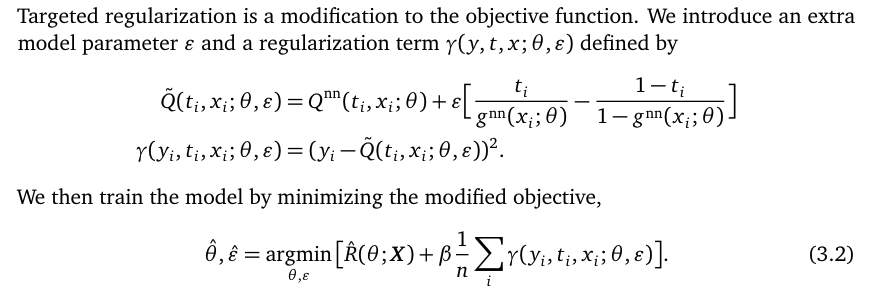

In [17]:
class EpsilonLayer(Layer):

    def __init__(self):
        super(EpsilonLayer, self).__init__()

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.epsilon = self.add_weight(name='epsilon',
                                       shape=[1, 1], # scalar
                                       initializer='RandomNormal',
                                       #  initializer='ones',
                                       trainable=True)
        super(EpsilonLayer, self).build(input_shape)  # Be sure to call this at the end

    #  This operation ensures that every sample in a batch has the same value of epsilon,
    #  but maintains the batch structure necessary for further calculations in a model.
    def call(self, inputs, **kwargs):
        # import ipdb; ipdb.set_trace()
        return self.epsilon * tf.ones_like(inputs)[:, 0:1]

## 🐲 Dragonnet w. Targeted Regularization ϵ

### 1. Model architecture

In [18]:
def make_dragonnet_tarreg(input_dim, reg_l2):

    inputs = Input(shape=(input_dim,), name='input')

    # representation
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(inputs)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)

    # t_predictions = Dense(units=1, activation='sigmoid')(inputs)
    # ***** (3) propensity score g layer ****
    t_predictions = Dense(units=1, activation='sigmoid')(x)

    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(
        y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(
        y1_hidden)

    # NEW!!!! For targeted regularization
    # ***** epsilon layer - look into the class ****
    dl = EpsilonLayer()
    # init this layer to make sure each element in the batch of t_predictions
    # will multiply the scalar value epsilon (trainable parameter) defult is 1
    epsilons = dl(t_predictions, name='epsilon')
    concat_pred = Concatenate(1)([y0_predictions, y1_predictions, t_predictions, epsilons])

    model = Model(inputs=inputs, outputs=concat_pred)

    return model



### 2. fit the model

The loss function for targeted regularization is dependent on both the original objective function R̂ and the regularizaiton term. The objective function is defined above in 3.2.

This loss function combines a typical prediction loss (dragonnet_loss_binarycross) with a targeted regularization term that adjusts predictions based on the influence of propensity score H + epsilon (trainable param).

In [19]:
# NEW LOSS FUNCTION!!!! for Tarreg

#  This loss function combines a typical prediction loss (dragonnet_loss_binarycross)
#  with a targeted regularization term
#  that adjusts predictions based on the influence of
#  propensity score H + epsilon (trainable param)
def make_tarreg_loss(ratio=1., dragonnet_loss=dragonnet_loss_binarycross):
    def tarreg_ATE_unbounded_domain_loss(concat_true, concat_pred):
        vanilla_loss = dragonnet_loss(concat_true, concat_pred)

        y_true = concat_true[:, 0]
        t_true = concat_true[:, 1]

        y0_pred = concat_pred[:, 0]
        y1_pred = concat_pred[:, 1]
        t_pred = concat_pred[:, 2]

        epsilons = concat_pred[:, 3]
        t_pred = (t_pred + 0.01) / 1.02
        y_pred = t_true * y1_pred + (1 - t_true) * y0_pred

        # ********* (4) Computing H - the influence of propensity score (treatment probability)
        #  on the perturbation. ******
        h = t_true / t_pred - (1 - t_true) / (1 - t_pred)
        # ********* Perturbed Outcomes - adjusts the
        # raw predictions based on the estimated treatment effect and the learned epsilon. ***********
        y_pert = y_pred + epsilons * h

        targeted_regularization = tf.reduce_sum(tf.square(y_true - y_pert))

        # final
        loss = vanilla_loss + ratio * targeted_regularization
        return loss

    return tarreg_ATE_unbounded_domain_loss



Additional to the metrics defined in the pure dragonnet. There's also a new metric to compute the average absolute value of epsilons across batches of data during training or evaluation monitor or track how large the epsilon values are, on average, across batches of data during training or evaluation

In [20]:
# Define metrics
# New Metric!!!

# compute the average absolute value of epsilons
# across batches of data during training or evaluation
# monitor or track how large the epsilon values are,
# on average, across batches of data during training or evaluation
def track_epsilon(concat_true, concat_pred):
    epsilons = concat_pred[:, 3]
    return tf.abs(tf.reduce_mean(epsilons))

metrics = [regression_loss, binary_classification_loss, treatment_accuracy, track_epsilon]

####Start training below

> Note: the default code use all the data for prediction and estimation. If you want to get the in-sample or out-sample error:  change the train_test_split criteria.



In [21]:
train_outputs = []
test_outputs = []

for idx, realization_data in enumerate(sorted(glob.glob("{}/*.npz".format('/content/data_ihdp_clean')))):
  # Prepare data for training (by default use all the data for train and prediction)
  print(realization_data)
  data = load(realization_data)
  x, t, y_unscaled = data['x'], data['t'], data['y']
  verbose = 0
  # ********(1) Transform of Y outcome *****************
  y_scaler = StandardScaler().fit(y_unscaled)
  y = y_scaler.transform(y_unscaled)

  i = 0
  tf.random.set_seed(i)
  np.random.seed(i)
  # If you want to get the in-sample or out-sample error:
  # i) change the train_test_split criteria
  train_index, test_index = train_test_split(np.arange(x.shape[0]), test_size=0.01, random_state=1)
  # ii) comment out the following: ----------
  all_index = np.append(train_index, test_index)
  print("All indices shape:", all_index.shape)
  test_index = all_index
  train_index = all_index
  # -------------------------------
  print("Train indices shape:", train_index.shape)
  print("Test indices shape:", test_index.shape)

  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  t_train, t_test = t[train_index], t[test_index]

  # two column matrix col1 = y,col 2 = t
  yt_train = np.concatenate([y_train, t_train], 1)

  # ********(2) Model Configuration (G-comp) ******************
  # Each takes the number of features (x.shape[1]) and a regularization parameter (0.01) as inputs.
  dragonnet = make_dragonnet_tarreg(x.shape[1], 0.01)

  # Start training
  import time;
  start_time = time.time()
  val_split = 0.2
  batch_size = 64
  # ------------DIFF---------------------
  ratio = 1.0
  loss = make_tarreg_loss(ratio=ratio, dragonnet_loss=dragonnet_loss_binarycross)
  # ------------DIFF---------------------
  metrics = metrics


  dragonnet.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=loss, metrics=metrics)

  adam_callbacks = [
      TerminateOnNaN(),
      EarlyStopping(monitor='val_loss', patience=2, min_delta=0.),
      ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=1e-8, cooldown=0, min_lr=0)

  ]

  dragonnet.fit(x_train, yt_train, callbacks=adam_callbacks,
                validation_split=val_split,
                epochs=100,
                batch_size=batch_size, verbose=verbose)

  sgd_callbacks = [
      TerminateOnNaN(),
      EarlyStopping(monitor='val_loss', patience=40, min_delta=0.),
      ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=0., cooldown=0, min_lr=0)
  ]

  sgd_lr = 1e-5
  momentum = 0.9
  dragonnet.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True), loss=loss,
                    metrics=metrics)
  dragonnet.fit(x_train, yt_train, callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size, verbose=verbose)

  elapsed_time = time.time() - start_time
  print("***************************** elapsed_time is: ", elapsed_time)

  yt_hat_test = dragonnet.predict(x_test)
  yt_hat_train = dragonnet.predict(x_train)

  test_outputs += [_split_output(yt_hat_test, t_test, y_test, y_scaler, x_test, test_index)]
  train_outputs += [_split_output(yt_hat_train, t_train, y_train, y_scaler, x_train, train_index)]


/content/data_ihdp_clean/simulation_0.npz
All indices shape: (747,)
Train indices shape: (747,)
Test indices shape: (747,)
***************************** elapsed_time is:  16.134366035461426
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
eps is trained
average propensity for treated: 0.23501861095428467 and untreated: 0.1609606295824051
eps is trained
average propensity for treated: 0.23501861095428467 and untreated: 0.1609606295824051
/content/data_ihdp_clean/simulation_1.npz
All indices shape: (747,)
Train indices shape: (747,)
Test indices shape: (747,)
***************************** elapsed_time is:  17.73011040687561
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
eps is trained
average propensity for treated: 0.23592732846736908 and untreated: 0.15757964551448822
eps is trained
average propensity for treated: 0.23592732846736908 and untreated: 0.15757964551448822
/content/data_ihdp_clean/simulation_2.npz
All indices sha

### Predicted outputs description

- **`q_t0`, `q_t1`**: Predicted outcomes under treatments 0 and 1, respectively.
- **`g`**: Predicted propensity score, estimating the probability of receiving the treatment given covariates.
- **`t`**: Indicator of treatment.
- **`y`**: Original outcome variable before any transformations.
- **`index`**: Unique identifier for each observation.
- **`eps`** (epsilon): Small constant used in calculations, typically to ensure numerical stability.

In [22]:
# save the outputs of for each split (1 per npz file)
train_output_dir = '/content/train_output_ihdp/dragonnet/tarreg'
if not os.path.exists(train_output_dir):
    os.makedirs(train_output_dir)

for num, output in enumerate(test_outputs):
    np.savez_compressed(os.path.join(train_output_dir, "{}_replication_test.npz".format(num)),
                        **output)

for num, output in enumerate(train_outputs):
    np.savez_compressed(os.path.join(train_output_dir, "{}_replication_train.npz".format(num)),
                        **output)

# STEP 2: Estimate ATE (Average Treatment Effect)

After predictions generated, we want to plug them into to the estimator for ATE. There are two estimator:

* natural estimator (1.2)
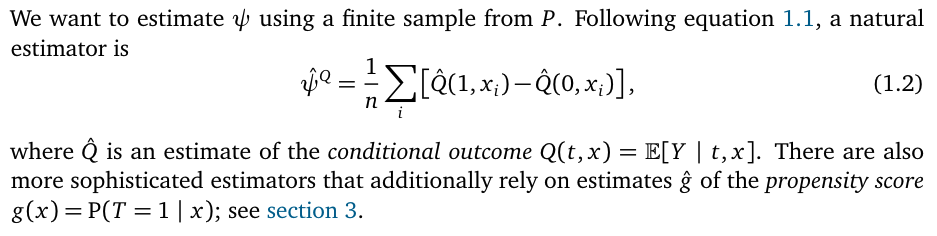

* Targeted Maximum Likelihood Estimation (TMLE):


Difference between TMLE and Targeted regularization

* TMLE uses only the ϵ to ensure non-parametric estimating equation are satisfied
* targeted regularization adpats the entire model, incorporate it in the training process?

Both are designed to yeild an estimate with stable finite-sample behavior and strong asymptotic auarantees.

Experiments will be run to compare the two (see section 5.2)

In [23]:
def load_data(knob, replication, model, train_test):
    """
    loading train test experiment results
    """
    output_dir = '/content/train_output_ihdp/{}/{}/'.format(knob,model)
    data = load(output_dir + '{}_replication_{}.npz'.format(replication, train_test))

    # q_t0,q_t1 -> predicted outcomes under (0,1) treatment
    # g -> predicted propensity score
    # t -> treatment
    # y -> original y before transformation
    # index
    # eps -> epsilon
    # NOTE: rechape (-1,1) return a two-dimensional array with one column and as many rows as necessary to accommodate all elements.

    return data['q_t0'].reshape(-1, 1), data['q_t1'].reshape(-1, 1), data['g'].reshape(-1, 1), \
           data['t'].reshape(-1, 1), data['y'].reshape(-1, 1), data['index'].reshape(-1, 1), data['eps'].reshape(-1, 1)


In [24]:
dict = {'tarnet': {'baseline': {'back_door': 0, }, 'tarreg': 0},
            'dragonnet': {'baseline': 0, 'tarreg': 0},
            'nednet': {'baseline': 0, 'tarreg': 0}}

tmle_dict = copy.deepcopy(dict)

In [25]:
n_replications = len(glob.glob("/content/data_ihdp_clean/*.npz"))
n_replications

5

In [26]:
def load_truth(replication, knob):
    """
    loading ground truth data
    """

    file_path = '/content/data_ihdp_clean/simulation_{}.npz'.format(replication)
    data = load(file_path)
    mu_0 = data['mu_0']
    mu_1 = data['mu_1']

    return mu_1, mu_0


In [27]:
# Helper functions, details in Appendix B, the purpose of the truncation
# is to minimize the effect of extreme propensity scores.
def truncate_by_g(attribute, g, level=0.01):
    keep_these = np.logical_and(g >= level, g <= 1.-level)

    return attribute[keep_these]


def truncate_all_by_g(q_t0, q_t1, g, t, y, truncate_level=0.05):
    """
    Helper function to clean up nuisance parameter estimates.

    """

    orig_g = np.copy(g)

    q_t0 = truncate_by_g(np.copy(q_t0), orig_g, truncate_level)
    q_t1 = truncate_by_g(np.copy(q_t1), orig_g, truncate_level)
    g = truncate_by_g(np.copy(g), orig_g, truncate_level)
    t = truncate_by_g(np.copy(t), orig_g, truncate_level)
    y = truncate_by_g(np.copy(y), orig_g, truncate_level)

    return q_t0, q_t1, g, t, y



def cross_entropy(y, p):
    return -np.mean((y*np.log(p) + (1.-y)*np.log(1.-p)))


def mse(x, y):
    return np.mean(np.square(x-y))


In [28]:
def psi_naive(q_t0, q_t1, g, t, y, truncate_level=0.):
    ite = (q_t1 - q_t0)
    return np.mean(truncate_by_g(ite, g, level=truncate_level))


def psi_tmle_cont_outcome(q_t0, q_t1, g, t, y, eps_hat=None, truncate_level=0.05):
    q_t0, q_t1, g, t, y = truncate_all_by_g(q_t0, q_t1, g, t, y, truncate_level)


    g_loss = mse(g, t)
    h = t * (1.0/g) - (1.0-t) / (1.0 - g)
    full_q = (1.0-t)*q_t0 + t*q_t1 # predictions from unperturbed model

    if eps_hat is None:
        eps_hat = np.sum(h*(y-full_q)) / np.sum(np.square(h))

    def q1(t_cf):
        # ***** Estimate H ******
        h_cf = t_cf * (1.0 / g) - (1.0 - t_cf) / (1.0 - g)
        full_q = (1.0 - t_cf) * q_t0 + t_cf * q_t1  # predictions from unperturbed model
        # ***** Update predictions with H, eps ******
        return full_q + eps_hat * h_cf

    # ***** average Treatment effect *****
    ite = q1(np.ones_like(t)) - q1(np.zeros_like(t))
    psi_tmle = np.mean(ite)

    # standard deviation computation relies on asymptotic expansion of non-parametric estimator, see van der Laan and Rose p 96
    ic = h*(y-q1(t)) + ite - psi_tmle
    psi_tmle_std = np.std(ic) / np.sqrt(t.shape[0])
    initial_loss = np.mean(np.square(full_q-y))
    final_loss = np.mean(np.square(q1(t)-y))


    return psi_tmle, psi_tmle_std, eps_hat, initial_loss, final_loss, g_loss


## 🐲 Dragonnet

In [29]:
simple_errors_dragonnet = []
tmle_errors_dragonnet = []
knob = 'dragonnet'
model = 'baseline'
train_test = 'train'

for rep in range(n_replications):
  q_t0, q_t1, g, t, y_dragon, index, eps = load_data(knob, rep, model, train_test)
  a, b = load_truth(rep,knob)
  mu_1, mu_0 = a[index], b[index]

  truth = (mu_1 - mu_0).mean()

  truncate_level=0.01
  psi_n = psi_naive(q_t0, q_t1, g, t, y_dragon, truncate_level=truncate_level)
  psi_tmle, psi_tmle_std, eps_hat, initial_loss, final_loss, g_loss = psi_tmle_cont_outcome(q_t0, q_t1, g, t,
                                                                                              y_dragon,
                                                                                              truncate_level=truncate_level)


  err = abs(truth - psi_n).mean()
  tmle_err = abs(truth - psi_tmle).mean()
  simple_errors_dragonnet.append(err)
  tmle_errors_dragonnet.append(tmle_err)

dict[knob][model] = np.mean(simple_errors_dragonnet)
tmle_dict[knob][model] = np.mean(tmle_errors_dragonnet)

print('simple error:',dict[knob][model])
print('tmle error:',tmle_dict[knob][model], ' with std: ',psi_tmle_std)

simple error: 0.10990943195106677
tmle error: 0.11145082937551179  with std:  0.1571342818964561


## 🐲 Dragonnet w. Targeted Regularization ϵ

In [30]:
simple_errors_dragonnet = []
tmle_errors_dragonnet = []
knob = 'dragonnet'
model = 'tarreg'
train_test = 'train'

for rep in range(n_replications):
  q_t0, q_t1, g, t, y_dragon, index, eps = load_data(knob, rep, model, train_test)
  a, b = load_truth(rep,knob)
  mu_1, mu_0 = a[index], b[index]

  truth = (mu_1 - mu_0).mean()

  truncate_level=0.01
  psi_n = psi_naive(q_t0, q_t1, g, t, y_dragon, truncate_level=truncate_level)
  psi_tmle, psi_tmle_std, eps_hat, initial_loss, final_loss, g_loss = psi_tmle_cont_outcome(q_t0, q_t1, g, t,
                                                                                              y_dragon,
                                                                                              truncate_level=truncate_level)

  err = abs(truth - psi_n).mean()
  tmle_err = abs(truth - psi_tmle).mean()
  simple_errors_dragonnet.append(err)
  tmle_errors_dragonnet.append(tmle_err)

dict[knob][model] = np.mean(simple_errors_dragonnet)
tmle_dict[knob][model] = np.mean(tmle_errors_dragonnet)


print('simple error:',dict[knob][model])
print('tmle error:',tmle_dict[knob][model], ' with std: ',psi_tmle_std)

simple error: 0.1022647360342491
tmle error: 0.09516844502092496  with std:  0.15383959709771053


In [31]:
dict

{'tarnet': {'baseline': {'back_door': 0}, 'tarreg': 0},
 'dragonnet': {'baseline': 0.10990943195106677, 'tarreg': 0.1022647360342491},
 'nednet': {'baseline': 0, 'tarreg': 0}}

In [32]:
tmle_dict

{'tarnet': {'baseline': {'back_door': 0}, 'tarreg': 0},
 'dragonnet': {'baseline': 0.11145082937551179, 'tarreg': 0.09516844502092496},
 'nednet': {'baseline': 0, 'tarreg': 0}}

# Comparing Dragonnet with other models TODO:

## Questions to be answered:

Do Dragonnet and targeted regularization improve treatment effect estimation in practice? Dragonnet is a high-capacity model trained end-to-end: does it actually throw away
information irrelevant to the propensity score? TMLE already offers an approach for balancing asymptotic guarantees with finite sample performance: does targeted regularization
improve over this?

## 🎯 TARNET






### 1. Model architecture

If the propensity-score head is removed from Dragonnet, the resulting architecture is TARNET

In [33]:
def make_tarnet(input_dim, reg_l2):

    inputs = Input(shape=(input_dim,), name='input')

    # representation
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(inputs)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)

    # ---ONLY difference from dragonnet-------
    t_predictions = Dense(units=1, activation='sigmoid')(inputs)
    # --------------------------

    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(
        y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(
        y1_hidden)

    concat_pred = Concatenate(1)([y0_predictions, y1_predictions, t_predictions])
    model = Model(inputs=inputs, outputs=concat_pred)

    return model



### 2. fit the model



> Note: the default code use all the data for prediction and estimation. If you want to get the in-sample or out-sample error:  change the train_test_split criteria.



In [34]:
# Define the loss functions
# minimize errors/loss for propensity score prediction (for exposure model)
def binary_classification_loss(concat_true, concat_pred):
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    # stabilizing the training process by avoiding issues with logarithmic calculations
    # in the next step (binary cross-entropy)
    t_pred = (t_pred + 0.001) / 1.002
    # Binary cross-entropy loss is a common choice for binary classification tasks
    # it measures the "distance" between the actual t and the predicted t
    losst = tf.reduce_sum(K.binary_crossentropy(t_true, t_pred))

    return losst

# minimize prediction errors separately for treated and untreated groups(for outcome model)
def regression_loss(concat_true, concat_pred):
    y_true = concat_true[:, 0]
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    loss0 = tf.reduce_sum((1. - t_true) * tf.square(y_true - y0_pred))
    loss1 = tf.reduce_sum(t_true * tf.square(y_true - y1_pred))

    return loss0 + loss1


# minimize both the prediction error for outcome + exposure models.
def dragonnet_loss_binarycross(concat_true, concat_pred):
    return regression_loss(concat_true, concat_pred) + binary_classification_loss(concat_true, concat_pred)


def treatment_accuracy(concat_true, concat_pred):
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    return tf.keras.metrics.binary_accuracy(t_true, t_pred)





In [35]:
# Define metrics
metrics = [regression_loss, binary_classification_loss, treatment_accuracy]

In [36]:
# Helper function
def _split_output(yt_hat, t, y, y_scaler, x, index):
    q_t0 = y_scaler.inverse_transform(yt_hat[:, 0].reshape(-1, 1))
    q_t1 = y_scaler.inverse_transform(yt_hat[:, 1].reshape(-1, 1))
    g = yt_hat[:, 2].copy()

    if yt_hat.shape[1] == 4:
        eps = yt_hat[:, 3][0]
        print('eps is trained')
    else:
        eps = np.zeros_like(yt_hat[:, 2])
        print('eps will be zero')

    y = y_scaler.inverse_transform(y.copy())
    var = "average propensity for treated: {} and untreated: {}".format(g[t.squeeze() == 1.].mean(),
                                                                        g[t.squeeze() == 0.].mean())
    print(var)

    # q_t0,q_t1 -> predicted outcomes under (0,1) treatment
    # g -> predicted propensity score
    # t -> treatment
    # y -> original y before transformation
    # index
    # eps -> epsilon
    return {'q_t0': q_t0, 'q_t1': q_t1, 'g': g, 't': t, 'y': y, 'x': x, 'index': index, 'eps': eps}


In [37]:
train_outputs = []
test_outputs = []
for idx, realization_data in enumerate(sorted(glob.glob("{}/*.npz".format('/content/data_ihdp_clean')))):
  # Prepare data for training (by default use all the data for train and prediction)
  print(realization_data)
  data = load(realization_data)
  x, t, y_unscaled = data['x'], data['t'], data['y']
  verbose = 0
  # ********(1) Transform of Y outcome *****************
  y_scaler = StandardScaler().fit(y_unscaled)
  y = y_scaler.transform(y_unscaled)

  i = 0
  tf.random.set_seed(i)
  np.random.seed(i)
  train_index, test_index = train_test_split(np.arange(x.shape[0]), test_size=0.01, random_state=1)
  test_index = train_index
  print("Train indices shape:", train_index.shape)

  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  t_train, t_test = t[train_index], t[test_index]

  # two column matrix col1 = y,col 2 = t
  yt_train = np.concatenate([y_train, t_train], 1)

  # ********(2) Model Configuration (G-comp) ******************
  # Each takes the number of features (x.shape[1]) and a regularization parameter (0.01) as inputs.
  tarnet = make_tarnet(x.shape[1], 0.01)

  # Start training
  import time;
  start_time = time.time()
  val_split = 0.2
  batch_size = 64
  loss = dragonnet_loss_binarycross
  metrics = metrics


  tarnet.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=loss, metrics=metrics)

  adam_callbacks = [
      TerminateOnNaN(),
      EarlyStopping(monitor='val_loss', patience=2, min_delta=0.),
      ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=1e-8, cooldown=0, min_lr=0)

  ]

  tarnet.fit(x_train, yt_train, callbacks=adam_callbacks,
                validation_split=val_split,
                epochs=100,
                batch_size=batch_size, verbose=verbose)

  sgd_callbacks = [
      TerminateOnNaN(),
      EarlyStopping(monitor='val_loss', patience=40, min_delta=0.),
      ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=0., cooldown=0, min_lr=0)
  ]

  sgd_lr = 1e-5
  momentum = 0.9
  tarnet.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True), loss=loss,
                    metrics=metrics)
  tarnet.fit(x_train, yt_train, callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size, verbose=verbose)

  elapsed_time = time.time() - start_time
  print("***************************** elapsed_time is: ", elapsed_time)

  yt_hat_test = tarnet.predict(x_test)
  print("yt_hat_test shape:", yt_hat_test.shape)
  yt_hat_train = tarnet.predict(x_train)
  print("yt_hat_train shape:", yt_hat_train.shape)

  test_outputs += [_split_output(yt_hat_test, t_test, y_test, y_scaler, x_test, test_index)]
  train_outputs += [_split_output(yt_hat_train, t_train, y_train, y_scaler, x_train, train_index)]


/content/data_ihdp_clean/simulation_0.npz
Train indices shape: (739,)
***************************** elapsed_time is:  23.790132999420166
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
yt_hat_test shape: (739, 3)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
yt_hat_train shape: (739, 3)
eps will be zero
average propensity for treated: 0.2106078714132309 and untreated: 0.18235822021961212
eps will be zero
average propensity for treated: 0.2106078714132309 and untreated: 0.18235822021961212
/content/data_ihdp_clean/simulation_1.npz
Train indices shape: (739,)


KeyboardInterrupt: 

In [ ]:
  # save the outputs of for each split (1 per npz file)
  train_output_dir = '/content/train_output_ihdp/tarnet/baseline'
  if not os.path.exists(train_output_dir):
      os.makedirs(train_output_dir)

  for num, output in enumerate(test_outputs):
      np.savez_compressed(os.path.join(train_output_dir, "{}_replication_test.npz".format(num)),
                          **output)

  for num, output in enumerate(train_outputs):
      np.savez_compressed(os.path.join(train_output_dir, "{}_replication_train.npz".format(num)),
                          **output)

In [ ]:
K.clear_session()

### estimate ATE

In [ ]:
simple_errors_tarnet = []
tmle_errors_tarnet = []
knob = 'tarnet'
model = 'baseline'
train_test = 'train'

for rep in range(n_replications):
  q_t0, q_t1, g, t, y_dragon, index, eps = load_data(knob, rep, model, train_test)
  a, b = load_truth(rep,knob)
  mu_1, mu_0 = a[index], b[index]

  truth = (mu_1 - mu_0).mean()

  truncate_level=0.01
  psi_n = psi_naive(q_t0, q_t1, g, t, y_dragon, truncate_level=truncate_level)
  psi_tmle, psi_tmle_std, eps_hat, initial_loss, final_loss, g_loss = psi_tmle_cont_outcome(q_t0, q_t1, g, t,
                                                                                              y_dragon,
                                                                                              truncate_level=truncate_level)

  err = abs(truth - psi_n).mean()
  tmle_err = abs(truth - psi_tmle).mean()
  simple_errors_tarnet.append(err)
  tmle_errors_tarnet.append(tmle_err)

dict[knob][model] = np.mean(simple_errors_tarnet)
tmle_dict[knob][model] = np.mean(tmle_errors_tarnet)


print('simple error:',dict[knob][model])
print('tmle error:',tmle_dict[knob][model], ' with std: ',psi_tmle_std)


## 🎯 TARNET w. Targeted Regularization ϵ

### 1. Model architecture

In [ ]:
def make_tarnet_tmle(input_dim, reg_l2):

    inputs = Input(shape=(input_dim,), name='input')

    # representation
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(inputs)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)

    t_predictions = Dense(units=1, activation='sigmoid')(inputs)

    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(
        y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(
        y1_hidden)

    # ***** epsilon layer - look into the class ****
    dl = EpsilonLayer()
    # init this layer to make sure each element in the batch of t_predictions
    # will multiply the scalar value epsilon (trainable parameter) defult is 1
    epsilons = dl(t_predictions, name='epsilon')
    concat_pred = Concatenate(1)([y0_predictions, y1_predictions, t_predictions, epsilons])

    model = Model(inputs=inputs, outputs=concat_pred)

    return model



### 2. fit the model

In [ ]:
# Define the loss functions
# minimize errors/loss for propensity score prediction (for exposure model)
def binary_classification_loss(concat_true, concat_pred):
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    # stabilizing the training process by avoiding issues with logarithmic calculations
    # in the next step (binary cross-entropy)
    t_pred = (t_pred + 0.001) / 1.002
    # Binary cross-entropy loss is a common choice for binary classification tasks
    # it measures the "distance" between the actual t and the predicted t
    losst = tf.reduce_sum(K.binary_crossentropy(t_true, t_pred))

    return losst

# minimize prediction errors separately for treated and untreated groups(for outcome model)
def regression_loss(concat_true, concat_pred):
    y_true = concat_true[:, 0]
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    loss0 = tf.reduce_sum((1. - t_true) * tf.square(y_true - y0_pred))
    loss1 = tf.reduce_sum(t_true * tf.square(y_true - y1_pred))

    return loss0 + loss1


# minimize both the prediction error for outcome + exposure models.
def dragonnet_loss_binarycross(concat_true, concat_pred):
    return regression_loss(concat_true, concat_pred) + binary_classification_loss(concat_true, concat_pred)



def treatment_accuracy(concat_true, concat_pred):
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    return tf.keras.metrics.binary_accuracy(t_true, t_pred)




In [ ]:
# NEW LOSS FUNCTION!!!! for Tarreg

#  This loss function combines a typical prediction loss (dragonnet_loss_binarycross)
#  with a targeted regularization term
#  that adjusts predictions based on the influence of
#  propensity score H + epsilon (trainable param)
def make_tarreg_loss(ratio=1., dragonnet_loss=dragonnet_loss_binarycross):
    def tarreg_ATE_unbounded_domain_loss(concat_true, concat_pred):
        vanilla_loss = dragonnet_loss(concat_true, concat_pred)

        y_true = concat_true[:, 0]
        t_true = concat_true[:, 1]

        y0_pred = concat_pred[:, 0]
        y1_pred = concat_pred[:, 1]
        t_pred = concat_pred[:, 2]

        epsilons = concat_pred[:, 3]
        t_pred = (t_pred + 0.01) / 1.02
        # t_pred = tf.clip_by_value(t_pred,0.01, 0.99,name='t_pred')

        y_pred = t_true * y1_pred + (1 - t_true) * y0_pred

        # ********* (4) Computing H - the influence of propensity score (treatment probability)
        #  on the perturbation. ******
        h = t_true / t_pred - (1 - t_true) / (1 - t_pred)
        # ********* Perturbed Outcomes - adjusts the
        # raw predictions based on the estimated treatment effect and the learned epsilon. ***********
        y_pert = y_pred + epsilons * h

        targeted_regularization = tf.reduce_sum(tf.square(y_true - y_pert))

        # final
        loss = vanilla_loss + ratio * targeted_regularization
        return loss

    return tarreg_ATE_unbounded_domain_loss



In [ ]:
# Define metrics

# New Metric!!!
# compute the average absolute value of epsilons
# across batches of data during training or evaluation
# monitor or track how large the epsilon values are,
# on average, across batches of data during training or evaluation
def track_epsilon(concat_true, concat_pred):
    epsilons = concat_pred[:, 3]
    return tf.abs(tf.reduce_mean(epsilons))

metrics = [regression_loss, binary_classification_loss, treatment_accuracy, track_epsilon]

In [ ]:
# Helper function
def _split_output(yt_hat, t, y, y_scaler, x, index):
    q_t0 = y_scaler.inverse_transform(yt_hat[:, 0].reshape(-1, 1))
    q_t1 = y_scaler.inverse_transform(yt_hat[:, 1].reshape(-1, 1))
    g = yt_hat[:, 2].copy()

    if yt_hat.shape[1] == 4:
        eps = yt_hat[:, 3][0]
        print('eps is trained')
        print(eps)
    else:
        eps = np.zeros_like(yt_hat[:, 2])
        print('eps will be zero')
        print(eps)

    y = y_scaler.inverse_transform(y.copy())
    var = "average propensity for treated: {} and untreated: {}".format(g[t.squeeze() == 1.].mean(),
                                                                        g[t.squeeze() == 0.].mean())
    print(var)

    # q_t0,q_t1 -> predicted outcomes under (0,1) treatment
    # g -> predicted propensity score
    # t -> treatment
    # y -> original y before transformation
    # index
    # eps -> epsilon
    return {'q_t0': q_t0, 'q_t1': q_t1, 'g': g, 't': t, 'y': y, 'x': x, 'index': index, 'eps': eps}


In [ ]:
train_outputs = []
test_outputs = []

for idx, realization_data in enumerate(sorted(glob.glob("{}/*.npz".format('/content/data_ihdp_clean')))):
  # Prepare data for training (by default use all the data for train and prediction)
  print(realization_data)
  data = load(realization_data)
  x, t, y_unscaled = data['x'], data['t'], data['y']
  verbose = 0
  # ********(1) Transform of Y outcome *****************
  y_scaler = StandardScaler().fit(y_unscaled)
  y = y_scaler.transform(y_unscaled)

  i = 0
  tf.random.set_seed(i)
  np.random.seed(i)
  train_index, test_index = train_test_split(np.arange(x.shape[0]), test_size=0.01, random_state=1)
  test_index = train_index

  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  t_train, t_test = t[train_index], t[test_index]

  # two column matrix col1 = y,col 2 = t
  yt_train = np.concatenate([y_train, t_train], 1)

  # ********(2) Model Configuration (G-comp) ******************
  # Each takes the number of features (x.shape[1]) and a regularization parameter (0.01) as inputs.
  tarnet = make_tarnet_tmle(x.shape[1], 0.01)

  # Start training
  import time;
  start_time = time.time()
  val_split = 0.2
  batch_size = 64
  # ------------DIFF---------------------
  ratio = 1.0
  loss = make_tarreg_loss(ratio=ratio, dragonnet_loss=dragonnet_loss_binarycross)
  # ------------DIFF---------------------
  metrics = metrics


  tarnet.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=loss, metrics=metrics)

  adam_callbacks = [
      TerminateOnNaN(),
      EarlyStopping(monitor='val_loss', patience=2, min_delta=0.),
      ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=1e-8, cooldown=0, min_lr=0)

  ]

  tarnet.fit(x_train, yt_train, callbacks=adam_callbacks,
                validation_split=val_split,
                epochs=100,
                batch_size=batch_size, verbose=verbose)

  sgd_callbacks = [
      TerminateOnNaN(),
      EarlyStopping(monitor='val_loss', patience=40, min_delta=0.),
      ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=0., cooldown=0, min_lr=0)
  ]

  sgd_lr = 1e-5
  momentum = 0.9
  tarnet.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True), loss=loss,
                    metrics=metrics)
  tarnet.fit(x_train, yt_train, callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size, verbose=verbose)

  elapsed_time = time.time() - start_time
  print("***************************** elapsed_time is: ", elapsed_time)

  yt_hat_test = tarnet.predict(x_test)
  yt_hat_train = tarnet.predict(x_train)

  test_outputs += [_split_output(yt_hat_test, t_test, y_test, y_scaler, x_test, test_index)]
  train_outputs += [_split_output(yt_hat_train, t_train, y_train, y_scaler, x_train, train_index)]


In [ ]:
# save the outputs of for each split (1 per npz file)
train_output_dir = '/content/train_output_ihdp/tarnet/tarreg'
if not os.path.exists(train_output_dir):
    os.makedirs(train_output_dir)

for num, output in enumerate(test_outputs):
    np.savez_compressed(os.path.join(train_output_dir, "{}_replication_test.npz".format(num)),
                        **output)

for num, output in enumerate(train_outputs):
    np.savez_compressed(os.path.join(train_output_dir, "{}_replication_train.npz".format(num)),
                        **output)

In [ ]:
K.clear_session()

### estimate ATE

In [ ]:
simple_errors_tarnet = []
tmle_errors_tarnet = []
knob = 'tarnet'
model = 'tarreg'
train_test = 'train'

for rep in range(n_replications):
  q_t0, q_t1, g, t, y_dragon, index, eps = load_data(knob, rep, model, train_test)
  a, b = load_truth(rep,knob)
  mu_1, mu_0 = a[index], b[index]

  truth = (mu_1 - mu_0).mean()

  truncate_level=0.01
  psi_n = psi_naive(q_t0, q_t1, g, t, y_dragon, truncate_level=truncate_level)
  psi_tmle, psi_tmle_std, eps_hat, initial_loss, final_loss, g_loss = psi_tmle_cont_outcome(q_t0, q_t1, g, t,
                                                                                              y_dragon,
                                                                                              truncate_level=truncate_level)

  err = abs(truth - psi_n).mean()
  tmle_err = abs(truth - psi_tmle).mean()
  simple_errors_tarnet.append(err)
  tmle_errors_tarnet.append(tmle_err)

dict[knob][model] = np.mean(simple_errors_tarnet)
tmle_dict[knob][model] = np.mean(tmle_errors_tarnet)

print('simple error:',dict[knob][model])
print('tmle error:',tmle_dict[knob][model], ' with std: ',psi_tmle_std)


# Experiment results


Dragonnet with targeted regularization is state-of-the-art among these methods. However,
the small sample size and limited simulation settings of IHDP make it difficult to draw
conclusions about the methods.

The main takeaways of table 1 are: i) Our baseline method
is a strong comparator and ii) reusing the same data for fitting the model and computing
the estimate works better than data splitting

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(dict).T  # Transpose to get models as rows and measures as columns

# Display the DataFrame
df

In [ ]:
tmle_dict
# Convert the dictionary to a DataFrame
tmle_df = pd.DataFrame(tmle_dict).T  # Transpose to get models as rows and measures as columns

# Display the DataFrame
tmle_df